In [1]:
%%capture
!pip install mediapipe



In [56]:
pip install opencv-contrib-python-headless

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [35]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:

# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [39]:
# X_points, Y_points, labels and detected files which are the images thar MediaPipe was able to detect the face  
x_points= []
y_points = []
labels = []
detected_files = []

# extracting the file names (2000 name)
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])

# detecting faces and extracting the points
faceModule = mediapipe.solutions.face_mesh
# looping over the file names to load the images and their corresponding mat file
for filename in file_names:
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')
    # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
          # appending the file names where have been detected.
          detected_files.append(filename)
          # detecting the face
          face = results.multi_face_landmarks[0]
          # initializing two lists to store the points for the image.
          X = []
          Y = []
          # looping over the 468 points of x and y
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image.
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # X_features
              X.append(relative_x)
              # Y_features
              Y.append(relative_y)

          # converting the lists to numpy arrays
          X = np.array(X)
          Y = np.array(Y)
          # appending the points of the images in the list of all image points
          x_points.append(X)
          y_points.append(Y)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          # appending the 3 angels to labels list
          labels.append(pose_para)

# converting features and labels to 2D array
x_points = np.array(x_points)
y_points = np.array(y_points)
labels = np.array(labels)

# the first label (pitch)
pitch_label = labels[:,0]
# the first label (yaw)
yaw_label = labels[:,1]
# the first label (roll)
roll_label = labels[:,2]


In [40]:
labels

array([[-0.39923078,  0.01822658,  0.08567622],
       [ 0.47006503,  1.18953335,  0.30095881],
       [-0.18464977,  0.88113666, -0.23685244],
       ...,
       [-0.15603451,  0.56711417, -0.10853576],
       [-0.19710165, -0.07043044,  0.1051178 ],
       [-0.01555222, -0.18012626, -0.02454621]])

In [41]:
print(x_points.shape)
print(y_points.shape)
print(labels.shape)

(1853, 468)
(1853, 468)
(1853, 3)


In [42]:
# center 99
# Top of Head = 10
# Bottom of Head = 171
x_center = x_points - x_points[:,99].reshape(-1,1)
y_center = y_points - y_points[:,99].reshape(-1,1)



In [43]:
# normalizing the data 
X_171 = x_points[:,171]
X_10 = x_points[:,10]
Y_171 = y_points[:,171]
Y_10 = y_points[:,10]
# computing the distance
distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),axis = 0).reshape(-1,1)
Norm_x = x_center / distance
Norm_y = y_center / distance
final_x = Norm_x
final_y = Norm_y
features = np.hstack([final_x,final_y])

In [44]:
pitch_model = XGBRegressor(verbosity = 0)
yaw_model = XGBRegressor(verbosity = 0)
roll_model = XGBRegressor(verbosity = 0)
pitch_crossval = cross_val_score(pitch_model,features,pitch_label,scoring="neg_mean_absolute_error")
yaw_crossval = cross_val_score(roll_model,features,roll_label,scoring="neg_mean_absolute_error")
roll_crossval = cross_val_score(yaw_model,features,yaw_label,scoring="neg_mean_absolute_error") 

print(pitch_crossval)
print(yaw_crossval)
print(roll_crossval)


[-0.17437726 -0.07866154 -0.12215745 -0.13985495 -0.12734324]
[-0.12356691 -0.04613395 -0.08485527 -0.11572249 -0.10174358]
[-0.1014985  -0.05949036 -0.08305039 -0.09671772 -0.09058931]


In [45]:
# computing the mean
print(pitch_crossval.mean())
print(yaw_crossval.mean())
print(roll_crossval.mean())

-0.1284788866082601
-0.0944044391427354
-0.08626925563107453


In [46]:
X_train,X_val,y_train,y_val,file_train,file_test = train_test_split(features,labels,detected_files,test_size = 0.2,random_state = 20)
y_train_pitch = y_train[:,0]
y_train_yaw = y_train[:,1]
y_train_roll = y_train[:,2]
y_val_pitch = y_val[:,0]
y_val_yaw = y_val[:,1]
y_val_roll = y_val[:,2]

In [47]:
xg_parameters = {'n_estimators': np.arange(7,15,2),'max_depth': np.arange(1,10,2),'learning_rate': np.arange(0.5,1,0.2)}


In [48]:
# grid search pitch
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_pitch = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_pitch.fit(X_train, y_train_pitch)
xg_pitch = xg_gs_pitch.best_estimator_
print(xg_pitch)
print("Train Error: ",mean_absolute_error(xg_pitch.predict(X_train),y_train_pitch))
print("Validation Error: ",mean_absolute_error(xg_pitch.predict(X_val),y_val_pitch))

XGBRegressor(learning_rate=0.8999999999999999, max_depth=1, n_estimators=13,
             verbosity=0)
Train Error:  0.12161729844072713
Validation Error:  0.15801939375778895


In [49]:
# grid search yaw
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_yaw = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_yaw.fit(X_train, y_train_yaw)
xg_yaw = xg_gs_yaw.best_estimator_
print(xg_yaw)
print("Train Error: ",mean_absolute_error(xg_yaw.predict(X_train),y_train_yaw))
print("Validation Error: ",mean_absolute_error(xg_yaw.predict(X_val),y_val_yaw))

XGBRegressor(learning_rate=0.5, max_depth=5, n_estimators=7, verbosity=0)
Train Error:  0.054236402385155764
Validation Error:  0.09444332542337196


In [50]:
# grid search roll
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_roll = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_roll.fit(X_train, y_train_roll)
xg_roll = xg_gs_roll.best_estimator_
print(xg_roll)
print("Train Error: ",mean_absolute_error(xg_roll.predict(X_train),y_train_roll))
print("Validation Error: ",mean_absolute_error(xg_roll.predict(X_val),y_val_roll))

XGBRegressor(learning_rate=0.5, max_depth=1, n_estimators=9, verbosity=0)
Train Error:  0.10835984985581051
Validation Error:  0.1533696710441065


In [51]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

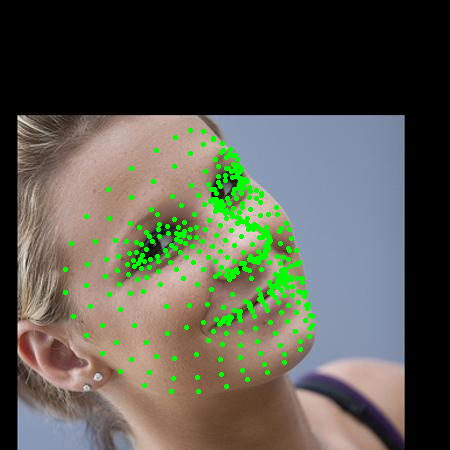

In [62]:
# choosing random image from the testing data
image_name = random.choice(file_test)
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # 
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            #cv2.putText(frame, str(j), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 2)
    cv2_imshow(frame)


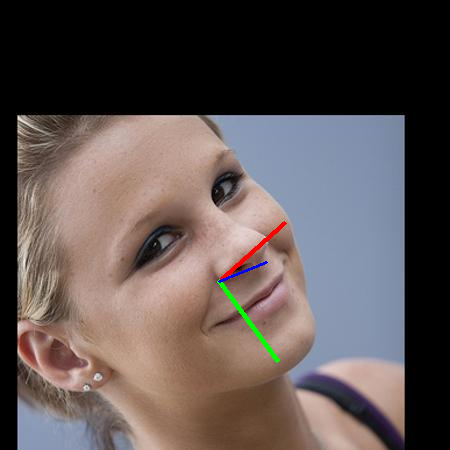

In [63]:
# reading the image
frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
# reading the true labels and drawing the axis on the image
mat = sio.loadmat('/content/AFLW2000/' + image_name + '.mat')
pitch_true = mat["Pose_Para"][0][0]
yaw_true = mat["Pose_Para"][0][1]
roll_true = mat["Pose_Para"][0][2]
cv2_imshow(draw_axis(frame,pitch_true,yaw_true,roll_true,X[99],Y[99]))


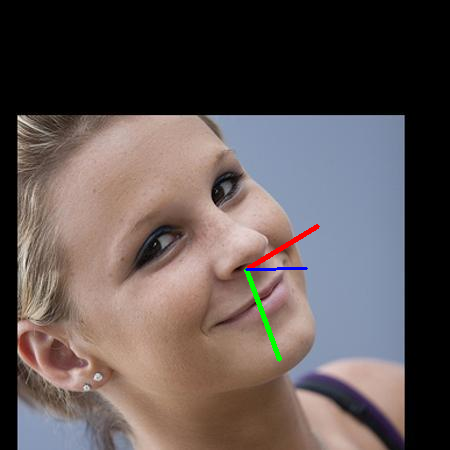

In [64]:
# choosing random image from the testing data
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists to store x and y points
        X = []
        Y = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            # getting the points back to its actual values
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            # appending the points to the X and Y lists
            X.append(relative_x)
            Y.append(relative_y)

        # converting the x and y points to numpy array
        X = np.array(X)
        Y = np.array(Y)

        # centering the points of x and y values arround the point no. 99
        x_center = X - X[99]
        y_center = Y - Y[99]
        # computing the distance between the point 171 and 10
        d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
        # normalizing the points
        X_norm = x_center/d
        Y_norm = y_center/d
        X_norm = X_norm
        Y_norm = Y_norm
        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
        pred_pitch = xg_gs_pitch.predict(points)
        pred_yaw = xg_gs_yaw.predict(points)
        pred_roll = xg_gs_roll.predict(points)
        cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[99],Y[99]))

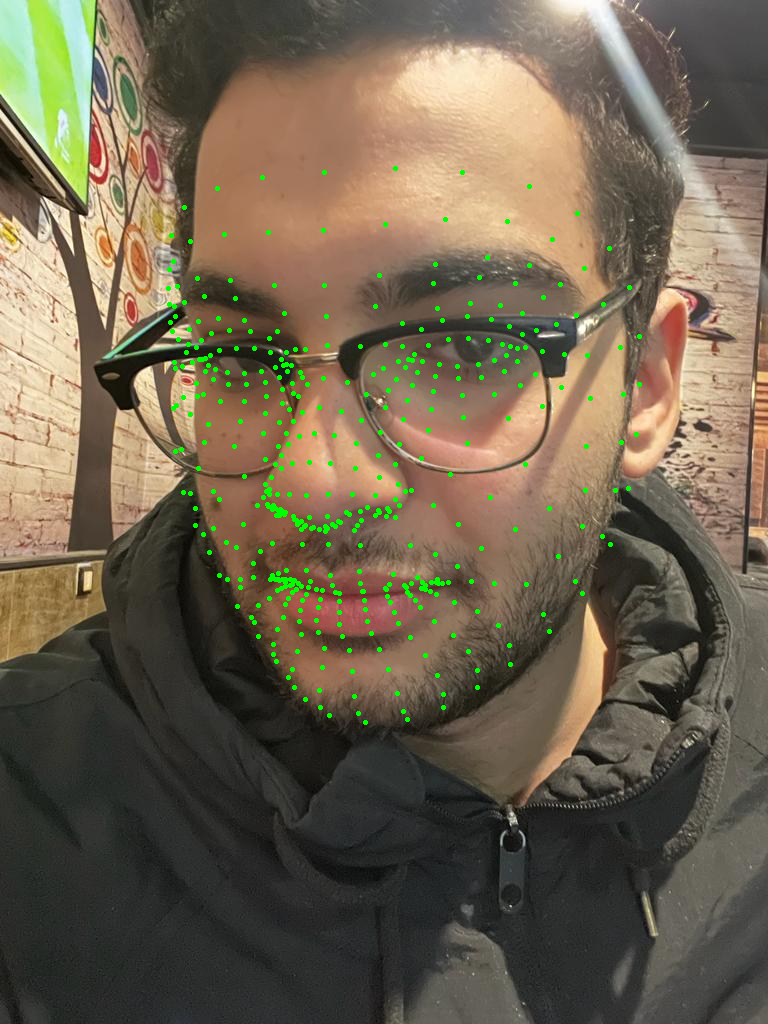

In [65]:
image_name = random.choice(file_test)
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/Muhab_Test.jpeg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # 
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            #cv2.putText(frame, str(j), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 2)
    cv2_imshow(frame)

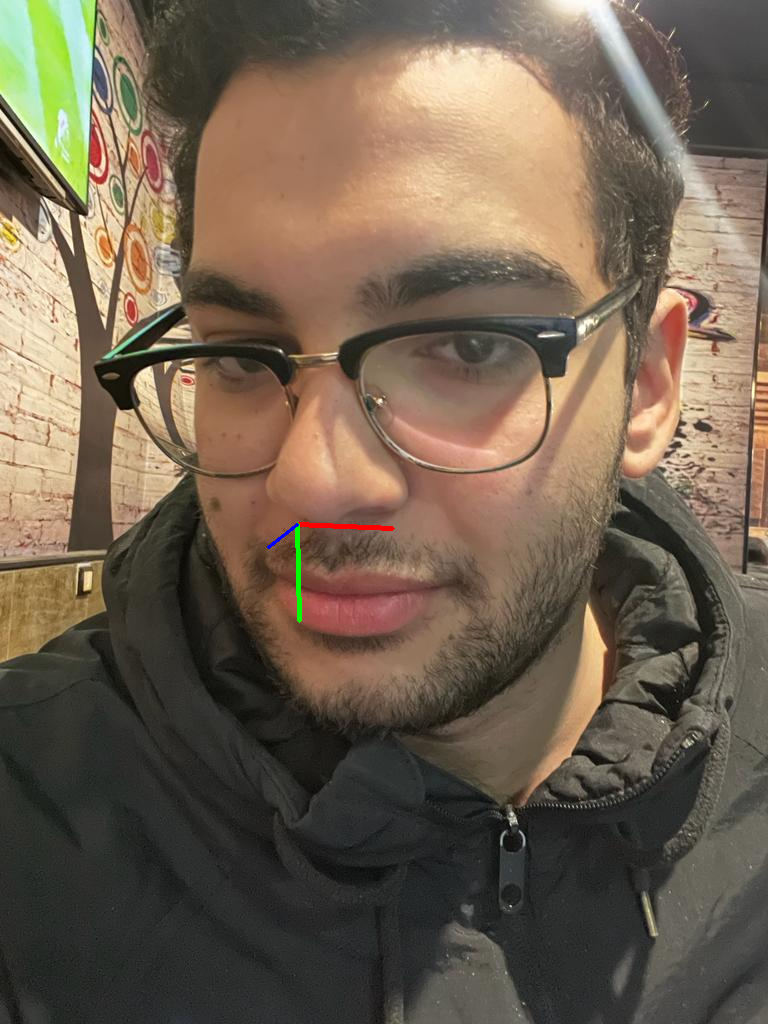

In [66]:
# choosing random image from the testing data
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/Muhab_Test.jpeg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists to store x and y points
        X = []
        Y = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            # getting the points back to its actual values
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            # appending the points to the X and Y lists
            X.append(relative_x)
            Y.append(relative_y)

        # converting the x and y points to numpy array
        X = np.array(X)
        Y = np.array(Y)

        # centering the points of x and y values arround the point no. 99
        x_center = X - X[99]
        y_center = Y - Y[99]
        # computing the distance between the point 171 and 10
        d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
        # normalizing the points
        X_norm = x_center/d
        Y_norm = y_center/d
        X_norm = X_norm
        Y_norm = Y_norm
        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
        pred_pitch = xg_gs_pitch.predict(points)
        pred_yaw = xg_gs_yaw.predict(points)
        pred_roll = xg_gs_roll.predict(points)
        cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[99],Y[99]))

In [68]:
# Create a VideoCapture object and read from input file
cap = cv2.VideoCapture('/content/Muhab3_Test_Video.mp4')
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video file")

# initializing a list to store the frames   
img_array = []
# Read until video is completed
while(cap.isOpened()):   
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
      with faceModule.FaceMesh(static_image_mode=True) as face:
        # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
        results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          for face in results.multi_face_landmarks:
              # initializing X and Y lists to store the spacial coordinates of the points
              X = []
              Y = []
              # looping over the landmarks to extract x and y
              for j,landmark in enumerate(face.landmark):
                  x = landmark.x
                  y = landmark.y
                  # retrieve the true values of x and y
                  shape = frame.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  X.append(relative_x)
                  Y.append(relative_y)

              X = np.array(X)
              Y = np.array(Y)
              # centering the data arround the point 99
              x_center = X - X[99]
              y_center = Y - Y[99]
              d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
              X_norm = x_center/d
              Y_norm = y_center/d
              X_norm = X_norm
              Y_norm = Y_norm
              points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
              # predicting the 3 angels to draw the axis on the image
              pred_pitch = xg_gs_pitch.predict(points)
              pred_yaw = xg_gs_yaw.predict(points)
              pred_roll = xg_gs_roll.predict(points)
              draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[99],Y[99])
              # appending the result frame to the img_array list
              img_array.append(frame)
    # Break the loop
    else: 
        break

cap.release()  
# Closes all the frames
# cv2.destroyAllWindows()
print("Number of Detected Frames = ",len(img_array))

Number of Detected Frames =  241


In [69]:
# converting the frames to video
out = cv2.VideoWriter('Muhab3-pose-estimation.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [70]:
from google.colab import files
files.download('Muhab3-pose-estimation.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>